# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

#rounding function
from math import ceil, sqrt


### Sample Size Calculation
We desire an improvement in the click through rate from 13% to 15%. We would also want the 2% difference to be statistically significant 85% of the time the difference is observed

In [2]:
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(.13, .15)

# sample size
required_n = sms.NormalIndPower().solve_power(effect_size=effect_size,
                                            power = .85,
                                            alpha= .05,
                                            ratio=1
                                            )

required_n = ceil(required_n)

print("Our effect size: ", effect_size, " Our required sample size for both control and treatment groups: ", required_n)


Our effect size:  -0.0576728617308947  Our required sample size for both control and treatment groups:  5399


In [3]:
# Calculate sample size needed


### Collecting and preparing the data

In [4]:
# Load the tiktok_data.csv into a dataframe
df = pd.read_csv('data/tiktok_data.csv')
df.head()

,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [5]:
# Get the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [6]:
# Make sure all the control group are seeing the star button and viceversa
check = pd.crosstab(df['group'],df['button'])
check

button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [7]:
# Check that no users have been sampled multiple times
print("shape of og df: ", df.shape)
user_counts = df['user_id'].value_counts()
mutli_users = user_counts[user_counts > 1].index


shape of og df:  (275781, 5)


In [8]:
# If there are users who have been sampled multiple times, remove them from the dataframe
df = df[~df['user_id'].isin(mutli_users)]
df.shape

(268875, 5)

In [9]:
# Make sure all the control group are seeing the star button and viceversa
control = pd.crosstab(df['group'],df['button'])
control

# better but still needs some cleaning

button,heart,star
group,,
control,134233,110
treatment,109,134423


In [10]:
print("Uncleaned dataset shape: ", df.shape)
df_control = df[df['group'] == 'control'].copy()
df_control_star = df_control[df_control['button'] == 'heart']

df_treatment = df[df['group'] == 'treatment'].copy()
df_treatment_heart = df_treatment[df_treatment['button'] == 'star']

df_clean = pd.concat([df_control_star, df_treatment_heart], ignore_index=True)
df_clean.shape
df.head()


Uncleaned dataset shape:  (268875, 5)


,user_id,timestamp,group,button,liked
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1
5,773302,2017-01-12 8:29:50,treatment,star,0


In [11]:
# Make sure all the control group are seeing the star button and viceversa
check = pd.crosstab(df_clean['group'],df_clean['button'])
check

button,heart,star
group,,
control,134233,0
treatment,0,134423


In [12]:
# replace OG df with clean df
df = df_clean

#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [13]:
# Perform simple random sampling to split the data into control and treatment
control_sample = df[df['group'] == 'control'].sample(n= required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n= required_n, random_state=22)

control_sample.shape,treatment_sample.shape

((5399, 5), (5399, 5))

In [14]:
# Create one table called ab_test that has both the cleaned control and treatment data
ab_test = pd.concat([control_sample, treatment_sample])
ab_test.shape

(10798, 5)

In [15]:
# Count the test groups to make sure that they're balanced


### Analysis Visualization

In [16]:
df.head()

,user_id,timestamp,group,button,liked
0,746742,2017-01-23 11:38:30,control,heart,0
1,913579,2017-01-24 9:11:39,control,heart,1
2,690284,2017-01-13 17:22:57,control,heart,0
3,710349,2017-01-11 22:24:44,control,heart,0
4,677533,2017-01-23 17:48:50,control,heart,0


In [17]:
df.shape, ab_test.shape

((268656, 5), (10798, 5))

In [18]:
# Find the like rate by group
control_selector = df[df['group'] == 'control']
treatment_selector = df[df['group'] == 'treatment']

control_like_rate = control_selector['liked'].mean()
treatment_like_rate = treatment_selector['liked'].mean()

print(f"like rate for control: {control_like_rate}\nlike rate for treatment: {treatment_like_rate}")

# Find the Std. deviation of the proportion
control_std = control_selector.liked.std()
treatment_std = treatment_selector.liked.std()

print(f"standard deviation of control: {control_std}\nstandard deviation of treatment:{treatment_std}")


# Find the Std. error of the proportion (std / sqrt(n))
control_se = control_std/sqrt(required_n)
treatment_se = treatment_std/sqrt(required_n)

print(f"standard error of control: {control_se}\nstandard error of treatment: {treatment_se}")

''' above is for the entire cleaned dataset. Code below is for the actual sampling dataset that should be used. You can see the results are very similar'''
# Calculate the final like rate. This is way easier than most of everything i did above except for standard error which is slightly different from sem
summary_stats = ab_test.groupby('group')['liked'].agg(['std', 'mean', 'sem', 'sum', 'count'])
summary_stats = summary_stats.reset_index()
summary_stats

like rate for control: 0.11965761027467166
like rate for treatment: 0.12385529262105444
standard deviation of control: 0.32456193759628577
standard deviation of treatment:0.32941761698962346
standard error of control: 0.004417137552265228
standard error of treatment: 0.004483221098441093


,group,std,mean,sem,sum,count
0,control,0.329934,0.124282,0.004490,671,5399
1,treatment,0.329723,0.124097,0.004487,670,5399


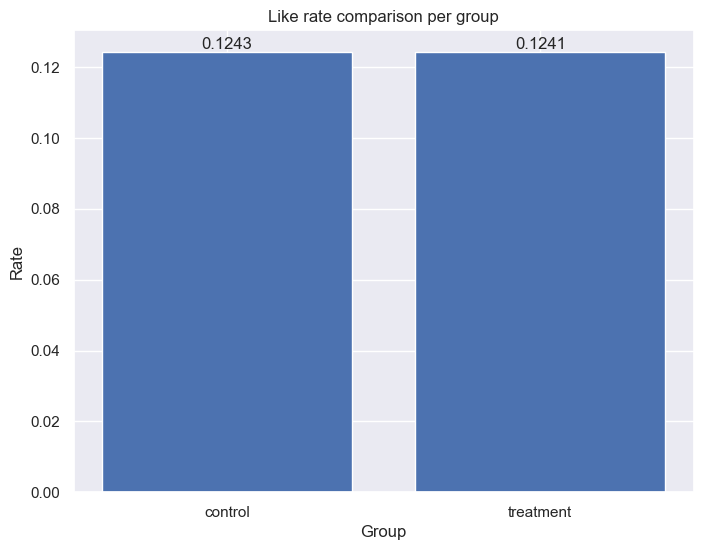

In [19]:
# Plot the like rate by group on a bar plot
fig, ax = plt.subplots(figsize=(8,6))

bars = ax.bar(ab_test['group'].unique(), ab_test['liked'].mean())

for bar, group, average in zip(bars, ab_test['group'], ab_test.groupby('group')['liked'].mean()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{round(average, 4)}', ha='center', va='bottom')

plt.title('Like rate comparison per group')
plt.xlabel('Group')
plt.ylabel('Rate')
plt.show()

### Testing for Stat Sig

In [41]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups
control_group = ab_test[ab_test['group'] == 'control']
control_like_count = control_group[control_group['liked'] ==  1]['liked'].count()


treatment_group = ab_test[ab_test['group'] == 'treatment']
treatment_like_count = treatment_group[treatment_group['liked'] ==  1]['liked'].count()

print(f"control like count: {control_like_count}\ntreatment_like_count: {treatment_like_count}")
# Get the number of samples in both groups
control_sample_count = control_group.group.count()

treatment_sample_count = treatment_group.group.count()
print(f"control group samples: {control_group.group.count()}\ntreatment group samples: {treatment_group.group.count()}")







# Sum up the number of successes (likes) in both groups
successes = [control_like_count.sum(), treatment_like_count.sum()]
print(f"number of successes(control vs treatment): {successes[0], successes[1]}")


control like count: 671
treatment_like_count: 670
control group samples: 5399
treatment group samples: 5399
number of successes(control vs treatment): (671, 670)


In [43]:
# Find the z statistic and p value for proportions based on normal ztest
z_stat, pval = proportions_ztest(successes,
                                  nobs=[control_sample_count,
                                         treatment_sample_count])

# Find the confidence intervals for each test group
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(successes,
                                                                                        nobs=[control_sample_count, treatment_sample_count],
                                                                                        alpha = .05)

In [45]:
# print z statistic
print(f'z statistic: {z_stat:.2f}')
# print p-value
print(f'p-value: {pval:.6f}')

# print ci 95% for control group
print(f'ci 95% for control group: [{lower_control:.3f}, {upper_control:.3f}]')

# print ci 95% for treatment group
print(f'ci 95% for treatment group: [{lower_treatment:.3f}, {upper_treatment:.3f}]')


z statistic: 0.03
p-value: 0.976721
ci 95% for control group: [0.115, 0.133]
ci 95% for treatment group: [0.115, 0.133]


### The confidence interval range doesn't include our target 3% increase from 6% conversion rate to 9% conversion rate 

### Were the results signficant? 

In [46]:
print("no, our p value is way above the alpha threshold of .05 or below")

no, our p value is way above the alpha threshold of .05 or below


### What would you advise the engineering team to do moving forward?

In [50]:
print("I would advise the engineering team to keep the button as a heart.\n \
      There is no difference in converting to the star\n \
      The performance with the star from the sample test also did worst")

I would advise the engineering team to keep the button as a heart.
       There is no difference in converting to the star
       The performance with the star from the sample test also did worst
